Some more information on the tarfile library can be found here:
https://docs.python.org/3/library/tarfile.html

Information on using pyarrow to manipulate parquet files
https://arrow.apache.org/docs/python/parquet.html#reading-parquet-and-memory-mapping

Information on reading parquet files with pandas
https://pandas.pydata.org/docs/reference/api/pandas.read_parquet.html

In [121]:
import tarfile
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [122]:
#Load tar.gz file into Python
#We are using 1 of 7
tar = tarfile.open("hitdata7days_0.tar.gz","r:gz")

#tar.next() example. But be careful to reinstantiate tar when needed
#gopes through each file in TAR file
#can be regular data file opr directory
tar.next()

#Extracting filename from TarInfo object
#Gives name of file - can be regular data file or directory 
tn = tar.next()
tn.name

#Check if TarInfo is a file or a directory
#Good condition to through in a loop
print(tn.isreg())
print(tn.isdir())

#Reading info from parquet file
#Gives info on data types of columns in 1 parquet file
#pq.read_schema(tn.name)

True
False


# Feature selection

In [123]:
#Read in parquet file as pandas DataFrame
#Turns parquet file into data frame
df = pd.read_parquet(tn.name)

#change from object to strings or ints
for names in df.columns:
    df[names] = df[names].convert_dtypes()

#function useful to see variable value counts of a specific column... i.e. for device type how many tablets, desktops, etc...
def seeValues(data, category):
    counts = pd.DataFrame(data.groupby([category])[category].count())
    counts.rename(columns={category: 'counts'}, inplace=True,)
    counts = counts.sort_values(['counts'], ascending=[0])
    graph = counts.reset_index()
    return graph

seeValues(df, 'devicetype')

,devicetype,counts
0,Mobile,68541
1,Tablet,31292
2,Desktop,25030
3,Unknown,4


In [124]:
#get master list of purchase visit ids
ids_purchase = (df[df['checkoutthankyouflag'] == 1])['visitid'].drop_duplicates()

#get master list of non-purhase visit ids
ids_no_purchase = (df[df['checkoutthankyouflag'] == 0])['visitid'].drop_duplicates()

In [125]:
#create DF w only beginning hit of the visit
#filter by checking when sevrer call time matches visit start time
df_first_visit = df[df['hit_time_gmt']==df['visitstarttimegmt']]

#oldest visits first
df_first_visit = df_first_visit.sort_values(by='hit_time_gmt', inplace = False)

#lastly, grab first click of each user, because there are some duplicates
df_first_visit = df_first_visit.drop_duplicates(subset=['visitid'], keep = "first", inplace = False)

len(df_first_visit)

5235

In [126]:
#data frame for percent of non-null values of each variable
percent = pd.DataFrame()

for names in df_first_visit.columns:
    percent[names] = [100 * (sum(seeValues(df_first_visit, names)['counts'])) / len(df_first_visit)]

#print(percent)

#data frame for percent of non-null values of each variable for PURCHASERS
purchase_percent = pd.DataFrame()
df_first_visit_purchases = df_first_visit[df_first_visit['visitid'].isin(ids_purchase)]

for names in df_first_visit_purchases.columns:
    purchase_percent[names] = [100 * (sum(seeValues(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]

#print(purchase_percent)

#data frame for percent of non-null values of each variable for NON-PURCHASERS
no_purchase_percent = pd.DataFrame()
df_first_visit_purchases = df_first_visit[df_first_visit['visitid'].isin(ids_no_purchase)]

for names in df_first_visit_purchases.columns:
    no_purchase_percent[names] = [100 * (sum(seeValues(df_first_visit_purchases, names)['counts'])) / len(df_first_visit_purchases)]

#print(no_purchase_percent )

/var/folders/kp/d_g66sj90ms008hjsl0pj80r0000gn/T/ipykernel_2862/593575511.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  percent[names] = [100 * (sum(seeValues(df_first_visit, names)['counts'])) / len(df_first_visit)]
/var/folders/kp/d_g66sj90ms008hjsl0pj80r0000gn/T/ipykernel_2862/593575511.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  percent[names] = [100 * (sum(seeValues(df_first_visit, names)['counts'])) / len(df_first_visit)]
/var/folders/kp/d_g66sj90ms008hjsl0pj80r0000gn/T/ipykernel_2862/593575511.py:5: Performa

In [127]:
#data frame for difference in percent of non-null values between PURCHASERS and NON-PURCHASERS
difference = purchase_percent - no_purchase_percent 

#pull features with a 10% di
significant = list()
for names in difference.columns:
    if abs(difference[names][0]) > 10:
        significant.append(names)

#print(difference[significant])
print(len(significant))

42


Text(0, 0.5, 'Number of Variables')

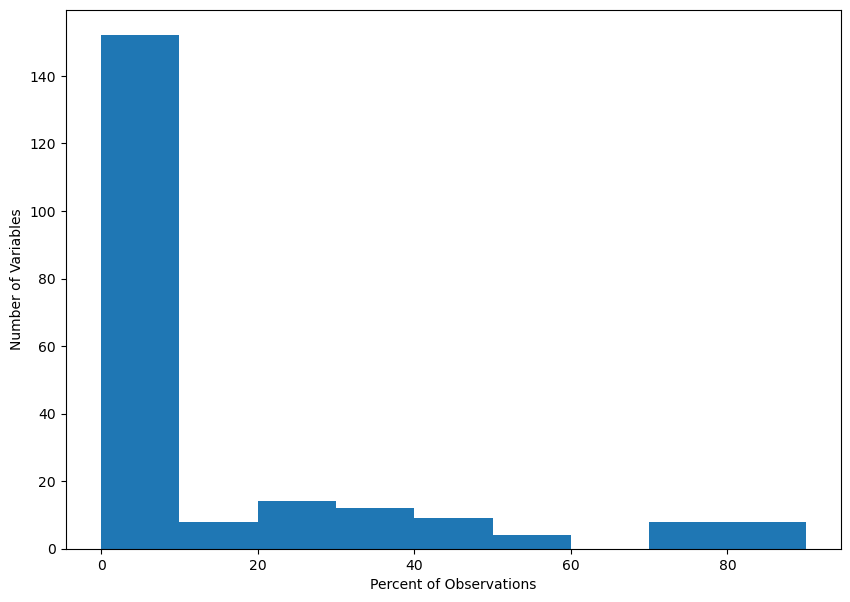

In [128]:
#histogram of variable frequency
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(percent.iloc[0,:], bins = range(0,100,10))
plt.xlabel("Percent of Observations")
plt.ylabel("Number of Variables")

In [129]:
#initialize empty lists for curating and removing features
features = list()
same_values = list()
mainly_same = list()

In [130]:
for names in percent.columns:
    if percent[names][0] > 10:
        features.append(names)

print(len(features))

for names in features:
    if len(seeValues(df_first_visit, names)) == 1:
        features.remove(names)
        same_values.append(names)

print(len(features))
#print(same_values)

for names in features:
    highest = (seeValues(df_first_visit, names)).iloc[0,1]
    total = len(df_first_visit)
    if highest/total > 0.90:
        features.remove(names)
        mainly_same.append(names)

#print(mainly_same)
print(features)


131
122
['hitdatahistorymkey', 'linenumber', 'visitoridhigh', 'visitoridlow', 'visitnumber', 'visitdatetime', 'fiscalmonthnumber', 'hit_time_gmt', 'service', 'eventlist', 'ip', 'pageevent', 'pageeventvar2', 'pageurl', 'pagename', 'productlist', 'sitesection', 'category', 'subcategory', 'subcategory2', 'pagecategory', 'myaccountengagement', 'formanalysis', 'emailsubscriptionremove', 'prop29', 'prop33', 'prop34', 'prop38', 'prop44', 'state', 'useragent', 'zip', 'browser', 'postbrowserheight', 'postbrowserwidth', 'postjavaenabled', 'color', 'connectiontype', 'country', 'domain', 'postttimeinfo', 'language_0001', 'os', 'resolution', 'lasthittimegmt', 'firsthittimegmt', 'visitstarttimegmt', 'lastpurchasetimegmt', 'lastpurchasenum', 'firsthitpagename', 'visitstartpagename', 'visitpagenum', 'geocity', 'georegion', 'newvisit', 'dailyvisitor', 'hourlyvisitor', 'monthlyvisitor', 'yearlyvisitor', 'warrantycategory', 'crosssoldproduct', 'calculatorengagement', 'customerconnection', 'evar23', 'evar

In [131]:
selected = df_first_visit[features]
highest = (seeValues(df_first_visit, 'devicetype')).iloc[0,1]
print(sum((seeValues(df_first_visit, 'devicetype')).iloc[:,1]))
selected = selected.fillna(str(0))
seeValues(selected, 'scene7')

5235


,scene7,counts
0,0,2669
1,1581,724
2,265,670
3,1129,402
4,1776,330
5,267,277
6,1775,48
7,471,45
8,1364,29
9,550,17


In [132]:
#removed because nonsense, redundant/crossover w other variables, infinite different values, or predominantly one value

#domain?
#browser?

remove_features = ['linenumber', 'visitoridhigh', 'visitoridlow', 
                 'fiscalmonthnumber','ip', 'useragent', 'browser',
                 'postjavaenabled', 'domain', 
                 'postttimeinfo', 'language_0001', 'os', 'lasthittimegmt', 
                 'firsthittimegmt']

for feature in remove_features:
    features.remove(feature)

print(features)

['hitdatahistorymkey', 'visitnumber', 'visitdatetime', 'hit_time_gmt', 'service', 'eventlist', 'pageevent', 'pageeventvar2', 'pageurl', 'pagename', 'productlist', 'sitesection', 'category', 'subcategory', 'subcategory2', 'pagecategory', 'myaccountengagement', 'formanalysis', 'emailsubscriptionremove', 'prop29', 'prop33', 'prop34', 'prop38', 'prop44', 'state', 'zip', 'postbrowserheight', 'postbrowserwidth', 'color', 'connectiontype', 'country', 'resolution', 'visitstarttimegmt', 'lastpurchasetimegmt', 'lastpurchasenum', 'firsthitpagename', 'visitstartpagename', 'visitpagenum', 'geocity', 'georegion', 'newvisit', 'dailyvisitor', 'hourlyvisitor', 'monthlyvisitor', 'yearlyvisitor', 'warrantycategory', 'crosssoldproduct', 'calculatorengagement', 'customerconnection', 'evar23', 'evar24', 'scene7', 'evar28', 'addonsymal', 'mvtparameters', 'freshstartcomplete', 'opentobuy', 'institutionid', 'cdeincreasepayment', 'cdedeferredoffer', 'cdedspomodel', 'post_evar7', 'post_evar8', 'post_evar9', 'pos